# Testing
### Passantenfrequenzen an der Bahnhofstrasse - Stundenwerte

https://data.stadt-zuerich.ch/dataset/hystreet_fussgaengerfrequenzen

Datum: 12.07.2022


### Importiere die notwendigen Packages

In [1]:
#%pip install geopandas altair fiona requests folium mplleaflet contextily seaborn datetime plotly leafmap


In [2]:
import pandas as pd
import pivottablejs
from pivottablejs import pivot_ui
import numpy as np
import altair as alt
import matplotlib.pyplot as plt

import datetime
import geopandas as gpd
import folium 
import plotly.express as px
import seaborn as sns
import leafmap

import requests
import io

import plotly.express as px


In [3]:
SSL_VERIFY = False
# evtl. SSL_VERIFY auf False setzen wenn die Verbindung zu https://www.gemeinderat-zuerich.ch nicht klappt (z.B. wegen Proxy)
# Um die SSL Verifikation auszustellen, bitte die nächste Zeile einkommentieren ("#" entfernen)
# SSL_VERIFY = False

In [4]:
if not SSL_VERIFY:
    import urllib3
    urllib3.disable_warnings()

Definiere Settings. Hier das Zahlenformat von Float-Werten (z.B. *'{:,.2f}'.format* mit Komma als Tausenderzeichen), 

In [5]:
#pd.options.display.float_format = lambda x : '{:,.1f}'.format(x) if (np.isnan(x) | np.isinf(x)) else '{:,.0f}'.format(x) if int(x) == x else '{:,.1f}'.format(x)
pd.options.display.float_format = '{:.0f}'.format
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 15)

### Zeitvariabeln
Bestimme den aktuellst geladenen Monat. Hier ist es der Stand vor 2 Monaten. 
Bestimme noch weitere evt. sinnvolle Zeitvariabeln.

Zum Unterschied zwischen import datetime und from datedtime import datetime, siehe https://stackoverflow.com/questions/15707532/import-datetime-v-s-from-datetime-import-datetime

Zuerst die Zeitvariabeln als Strings

In [6]:
#today_date = datetime.date.today()
#date_time = datetime.datetime.strptime(date_time_string, '%Y-%m-%d %H:%M')
now = datetime.date.today()
date_today = now.strftime("%Y-%m-%d")
year_today = now.strftime("%Y")
month_today = now.strftime("%m")
day_today = now.strftime("%d")



Und hier noch die Zeitvariabeln als Integers:
- `aktuellesJahr`
- `aktuellerMonat`: Der gerade jetzt aktuelle Monat
- `selectedMonat`: Der aktuellste Monat in den Daten. In der Regel zwei Monate her.

In [7]:
#now = datetime.now() 
int_times = now.timetuple()

aktuellesJahr = int_times[0]
aktuellerMonat = int_times[1]
selectedMonat = int_times[1]-2

print(aktuellesJahr, 
      aktuellerMonat,
    'datenstand: ', selectedMonat,
     int_times)


2023 1 datenstand:  -1 time.struct_time(tm_year=2023, tm_mon=1, tm_mday=20, tm_hour=0, tm_min=0, tm_sec=0, tm_wday=4, tm_yday=20, tm_isdst=-1)


### Setze einige Pfadvariabeln

- Der Packagename ist eigentlich der **Verzeichnisname** unter dem die Daten und Metadaten auf der Dropzone abgelegt werden.
- Definiert wird er bei SASA-Prozessen auf dem **Produkte-Sharepoint ([Link](https://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/PersonalViews.aspx?PageView=Personal&ShowWebPart={6087A3E7-8AC8-40BA-8278-DECFACE124FF}))**.
- Der Packagename wird auf CKAN teil der URL, daher ist die exakte Schreibweise wichtig.

Beachte: im Packagename müssen alle Buchstaben **klein** geschrieben werden. Dies weil CKAN aus grossen kleine Buchstaben macht.

**BITTE HIER ANPASSEN**

In [8]:
package_name = "hystreet_fussgaengerfrequenzen"

In [9]:
dataset_name = "hystreet_fussgaengerfrequenzen_seit2021.csv"

**Statische Pfade in DWH-Dropzones**

In [10]:
dropzone_path_integ = r"\\szh\ssz\applikationen\OGD_Dropzone\INT_DWH"

In [11]:
dropzone_path_prod = r"\\szh\ssz\applikationen\OGD_Dropzone\DWH"

**Statische Pfade CKAN-URLs**

In [12]:
ckan_integ_url ="https://data.integ.stadt-zuerich.ch/dataset/"

In [13]:
ckan_prod_url ="https://data.stadt-zuerich.ch/dataset/"

### Checke die Metadaten auf der CKAN INTEG- oder PROD-Webseite

Offenbar lassen sich aktuell im Markdownteil keine Variabeln ausführen, daher gehen wir wie unten gezeigt vor. Siehe dazu: https://data-dive.com/jupyterlab-markdown-cells-include-variables
Instead of setting the cell to Markdown, create Markdown from withnin a code cell! We can just use python variable replacement syntax to make the text dynamic

In [14]:
from IPython.display import Markdown as md

In [15]:
md(" **1. Dataset auf INTEG-Datakatalog:** Link {} ".format(ckan_integ_url+package_name))

 **1. Dataset auf INTEG-Datakatalog:** Link https://data.integ.stadt-zuerich.ch/dataset/hystreet_fussgaengerfrequenzen 

In [16]:
md(" **2. Dataset auf PROD-Datakatalog:** Link {} ".format(ckan_prod_url+package_name))

 **2. Dataset auf PROD-Datakatalog:** Link https://data.stadt-zuerich.ch/dataset/hystreet_fussgaengerfrequenzen 

### Importiere einen Datensatz 

Definiere zuerst folgende Werte:
1) Kommt der Datensatz von PROD oder INTEG?
2) Beziehst Du den Datensatz direkt ab der DROPZONE oder aus dem INTERNET?

In [17]:
#Die Datasets sind nur zum Testen auf INT-DWH-Dropzone. Wenn der Test vorbei ist, sind sie auf PROD. 
# Über den Status kann man einfach switchen

status = "prod"; #prod vs something else
data_source = "web"; #dropzone vs something else
print(status+" - "+ data_source)

prod - web


In [18]:
# Filepath
if status == "prod":
    if data_source == "dropzone":
            fp = dropzone_path_prod+"\\"+ package_name +"\\"+dataset_name
            print("fp lautet:"+fp)
    else:
        #fp = r"https://data.stadt-zuerich.ch/dataset/bau_neubau_whg_bausm_rinh_geb_projstatus_quartier_seit2009_od5011/download/BAU501OD5011.csv"
        fp = ckan_prod_url+package_name+'/download/'+dataset_name
        print("fp lautet:"+fp)
else:
    if data_source == "dropzone":
        fp = dropzone_path_integ+"\\"+ package_name +"\\"+dataset_name
        print("fp lautet:"+fp)
    else:
        #fp = r"https://data.stadt-zuerich.ch/dataset/bau_neubau_whg_bausm_rinh_geb_projstatus_quartier_seit2009_od5011/download/BAU501OD5011.csv"
        fp = ckan_integ_url+package_name+'/download/'+dataset_name
        print("fp lautet:"+fp)


fp lautet:https://data.stadt-zuerich.ch/dataset/hystreet_fussgaengerfrequenzen/download/hystreet_fussgaengerfrequenzen_seit2021.csv


Beachte, wie das SAS Datum (ohne Format) in ein UNIX Datum umgerechnet und als Datumsformat dargestellt wird! Siehe dazu `https://stackoverflow.com/questions/26923564/convert-sas-numeric-to-python-datetime`

In [19]:
# Read the data
if data_source == "dropzone":
    data2betested = pd.read_csv(
        fp
        , sep=','
        ,parse_dates=['timestamp']
        ,low_memory=False
    )
    print("dropzone")
else:
    r = requests.get(fp, verify=False)  
    r.encoding = 'utf-8'
    data2betested = pd.read_csv(
        io.StringIO(r.text)
        ,parse_dates=['timestamp']
        # KONVERTIERE DAS SAS DATUM IN EIN UNIXDATUM UND FORMATIERE ES
        #, date_parser=lambda s: epoch + datetime.timedelta(days=int(s))
        ,low_memory=False)
    print("web")

#data2betested.dtypes

web


In [20]:
date_today = now.strftime("%Y-%m-%d")
year_today = now.strftime("%Y")
month_today = now.strftime("%m")
day_today = now.strftime("%d")

Berechne weitere Attribute falls notwendig

In [21]:
data2betested = (
    data2betested
    .copy()
    .assign(
        #Aktualisierungs_Datum_str= lambda x: x.Aktualisierungs_Datum.astype(str),
        timestamp_str = lambda x: x.timestamp.astype(str),
        day_str = lambda x: x.timestamp.dt.strftime("%Y-%m-%d %H:%M"),       
        hour_str = lambda x: x.timestamp.dt.strftime("%H:%M"),  
        weekday = lambda x: x.timestamp.dt.dayofweek,
        weekday_name = lambda x: x.timestamp.dt.day_name(),
        year = lambda x: x.timestamp.dt.year,
        month = lambda x: x.timestamp.dt.month,
        day = lambda x: x.timestamp.dt.day
    )
    .sort_values('timestamp', ascending=False)
    )
#data2betested.columns
#data2betested.dtypes
data2betested

timestamp  location_id           location_name     ltr_label     rtl_label  \
34466 2023-01-20 14:00:00+00:00          330    Bahnhofstrasse (Süd)   Bürkliplatz  Hauptbahnhof   
34465 2023-01-20 14:00:00+00:00          331   Bahnhofstrasse (Nord)   Bürkliplatz  Hauptbahnhof   
34464 2023-01-20 14:00:00+00:00          329  Bahnhofstrasse (Mitte)  Hauptbahnhof   Bürkliplatz   
34463 2023-01-20 13:00:00+00:00          330    Bahnhofstrasse (Süd)   Bürkliplatz  Hauptbahnhof   
34462 2023-01-20 13:00:00+00:00          331   Bahnhofstrasse (Nord)   Bürkliplatz  Hauptbahnhof   
...                         ...          ...                     ...           ...           ...   
3     2021-09-28 23:00:00+00:00          329  Bahnhofstrasse (Mitte)  Hauptbahnhof   Bürkliplatz   
5     2021-09-28 23:00:00+00:00          330    Bahnhofstrasse (Süd)   Bürkliplatz  Hauptbahnhof   
2     2021-09-28 22:00:00+00:00          330    Bahnhofstrasse (Süd)   Bürkliplatz  Hauptbahnhof   
1     2021-09-28 22:00:00+00:00          331   Bahnhofstrasse (Nord)   Bürkliplatz  Hauptbahnhof   
0     2021-09-28 22:00:00+00:00          329  Bahnhofstrasse (Mitte)  Hauptbahnhof   Bürkliplatz   

       weather_condition  temperature  ...           day_str  hour_str  weekday  weekday_name  \
34466  partly-cloudy-day            1  ...  2023-01-20 14:00     14:00        4        Friday   
34465  partly-cloudy-day            1  ...  2023-01-20 14:00     14:00        4        Friday   
34464  partly-cloudy-day            1  ...  2023-01-20 14:00     14:00        4        Friday   
34463  partly-cloudy-day            1  ...  2023-01-20 13:00     13:00        4        Friday   
34462  partly-cloudy-day            1  ...  2023-01-20 13:00     13:00        4        Friday   
...                  ...          ...  ...               ...       ...      ...           ...   
3                 cloudy           13  ...  2021-09-28 23:00     23:00        1       Tuesday   
5                 cloudy           13  ...  2021-09-28 23:00     23:00        1       Tuesday   
2                 cloudy           14  ...  2021-09-28 22:00     22:00        1       Tuesday   
1                 cloudy           14  ...  2021-09-28 22:00     22:00        1       Tuesday   
0                 cloudy           14  ...  2021-09-28 22:00     22:00        1       Tuesday   

       year  month  day  
34466  2023      1   20  
34465  2023      1   20  
34464  2023      1   20  
34463  2023      1   20  
34462  2023      1   20  
...     ...    ...  ...  
3      2021      9   28  
5      2021      9   28  
2      2021      9   28  
1      2021      9   28  
0      2021      9   28  

[34467 rows x 45 columns]

### Einfache Datentests

 - 1) Zeige eine kurze Vorschau der importierten Daten
 - 2) Weise die Datentypen aus
 - 3) Zeige die Shape (Umfang) des Datensatzes an

Zeige einen Auszug der Daten

In [22]:
data2betested.head(3).T
#data2betested.sample(3).T

34466                      34465  \
timestamp                        2023-01-20 14:00:00+00:00  2023-01-20 14:00:00+00:00   
location_id                                            330                        331   
location_name                         Bahnhofstrasse (Süd)      Bahnhofstrasse (Nord)   
ltr_label                                      Bürkliplatz                Bürkliplatz   
rtl_label                                     Hauptbahnhof               Hauptbahnhof   
weather_condition                        partly-cloudy-day          partly-cloudy-day   
temperature                                              1                          1   
pedestrians_count                                        0                          0   
unverified                                            True                       True   
ltr_pedestrians_count                                    0                          0   
rtl_pedestrians_count                                    0                          0   
adult_pedestrians_count                                  0                          0   
child_pedestrians_count                                  0                          0   
adult_ltr_pedestrians_count                              0                          0   
adult_rtl_pedestrians_count                              0                          0   
child_ltr_pedestrians_count                              0                          0   
child_rtl_pedestrians_count                              0                          0   
zone_1_pedestrians_count                                 0                          0   
zone_1_ltr_pedestrians_count                             0                          0   
zone_1_rtl_pedestrians_count                             0                          0   
zone_1_adult_pedestrians_count                           0                          0   
zone_1_child_pedestrians_count                           0                          0   
zone_2_pedestrians_count                                 0                          0   
zone_2_ltr_pedestrians_count                             0                          0   
zone_2_rtl_pedestrians_count                             0                          0   
zone_2_adult_pedestrians_count                           0                          0   
zone_2_child_pedestrians_count                           0                          0   
zone_3_pedestrians_count                                 0                          0   
zone_3_ltr_pedestrians_count                             0                          0   
zone_3_rtl_pedestrians_count                             0                          0   
zone_3_adult_pedestrians_count                           0                          0   
zone_3_child_pedestrians_count                           0                          0   
zone_99_pedestrians_count                              NaN                        NaN   
zone_99_ltr_pedestrians_count                          NaN                        NaN   
zone_99_rtl_pedestrians_count                          NaN                        NaN   
zone_99_adult_pedestrians_count                        NaN                        NaN   
zone_99_child_pedestrians_count                        NaN                        NaN   
timestamp_str                    2023-01-20 14:00:00+00:00  2023-01-20 14:00:00+00:00   
day_str                                   2023-01-20 14:00           2023-01-20 14:00   
hour_str                                             14:00                      14:00   
weekday                                                  4                          4   
weekday_name                                        Friday                     Friday   
year                                                  2023                       2023   
month                                                    1                          1   
day                                             

In [23]:
# drop columns that have no values
# data2betested.dropna(how='all', axis=1, inplace=True)

Beschreibe kurz den Datensatz

In [24]:
print(f'The dataset has {data2betested.shape[0]:,.0f} rows (observations) and {data2betested.shape[1]:,.0f} columns (variables).')
print(f'There seem to be {data2betested.duplicated().sum()} exact duplicates in the data.')

The dataset has 34,467 rows (observations) and 45 columns (variables).
There seem to be 0 exact duplicates in the data.


Zeige Infos zu den Attributen

In [25]:
data2betested.info(memory_usage='deep', verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34467 entries, 34466 to 0
Data columns (total 45 columns):
 #   Column                           Non-Null Count  Dtype              
---  ------                           --------------  -----              
 0   timestamp                        34467 non-null  datetime64[ns, UTC]
 1   location_id                      34467 non-null  int64              
 2   location_name                    34467 non-null  object             
 3   ltr_label                        34467 non-null  object             
 4   rtl_label                        34467 non-null  object             
 5   weather_condition                34467 non-null  object             
 6   temperature                      34467 non-null  float64            
 7   pedestrians_count                34467 non-null  int64              
 8   unverified                       34467 non-null  bool               
 9   ltr_pedestrians_count            34467 non-null  int64              
 10

Beschreibe nicht numerische Attribute

In [26]:
# describe non-numerical features
try:
    with pd.option_context('display.float_format', '{:,.2f}'.format):
        display(data2betested.describe(exclude='number'))
except:
    print("No categorical data in dataset.")

timestamp         location_name    ltr_label     rtl_label  \
count                       34467                 34467        34467         34467   
unique                      11489                     3            2             2   
top     2023-01-20 14:00:00+00:00  Bahnhofstrasse (Süd)  Bürkliplatz  Hauptbahnhof   
freq                            3                 11489        22978         22978   
first   2021-09-28 22:00:00+00:00                   NaN          NaN           NaN   
last    2023-01-20 14:00:00+00:00                   NaN          NaN           NaN   

       weather_condition unverified              timestamp_str           day_str hour_str  \
count              34467      34467                      34467             34467    34467   
unique                 9          2                      11489             11489       24   
top               cloudy      False  2023-01-20 14:00:00+00:00  2023-01-20 14:00    14:00   
freq                8340      34419                          3                 3     1437   
first                NaN        NaN                        NaN               NaN      NaN   
last                 NaN        NaN                        NaN               NaN      NaN   

       weekday_name  
count         34467  
unique            7  
top        Thursday  
freq           4968  
first           NaN  
last            NaN

Beschreibe numerische Attribute

In [27]:
# describe numerical features
try:
    with pd.option_context('display.float_format', '{:,.0f}'.format):
        display(data2betested.describe(include='number'))
except:
    print("No numercial data in dataset.")

location_id  temperature  pedestrians_count  ltr_pedestrians_count  rtl_pedestrians_count  \
count       34,467       34,467             34,467                 34,467                 34,467   
mean           330           10              1,073                    550                    523   
std              1            8              1,249                    671                    610   
min            329           -9                  0                      0                      0   
25%            329            4                112                     53                     54   
50%            330            9                696                    331                    327   
75%            331           16              1,606                    822                    800   
max            331           35             16,481                 14,396                 11,445   

       adult_pedestrians_count  child_pedestrians_count  ...  zone_99_rtl_pedestrians_count  \
count                   34,467                   34,467  ...                            336   
mean                       974                       99  ...                              1   
std                      1,254                      320  ...                             10   
min                          0                        0  ...                              0   
25%                         19                        3  ...                              0   
50%                        488                       15  ...                              0   
75%                      1,514                       40  ...                              0   
max                     16,397                    4,579  ...                            152   

       zone_99_adult_pedestrians_count  zone_99_child_pedestrians_count  weekday   year  month  \
count                              336                              336   34,467 34,467 34,467   
mean                                 0                                2        3  2,022      7   
std                                  0                               22        2      0      4   
min                                  0                                0        0  2,021      1   
25%                                  0                                0        1  2,022      4   
50%                                  0                                0        3  2,022      8   
75%                                  0                                0        5  2,022     11   
max                                  0                              316        6  2,023     12   

         day  
count 34,467  
mean      16  
std        9  
min        1  
25%        8  
50%       15  
75%       23  
max       31  

[8 rows x 35 columns]

#### Wie viele Missings gibt es im Datensatz?

In [28]:
# check missing values with missingno
# https://github.com/ResidentMario/missingno
import missingno as msno


<AxesSubplot:>

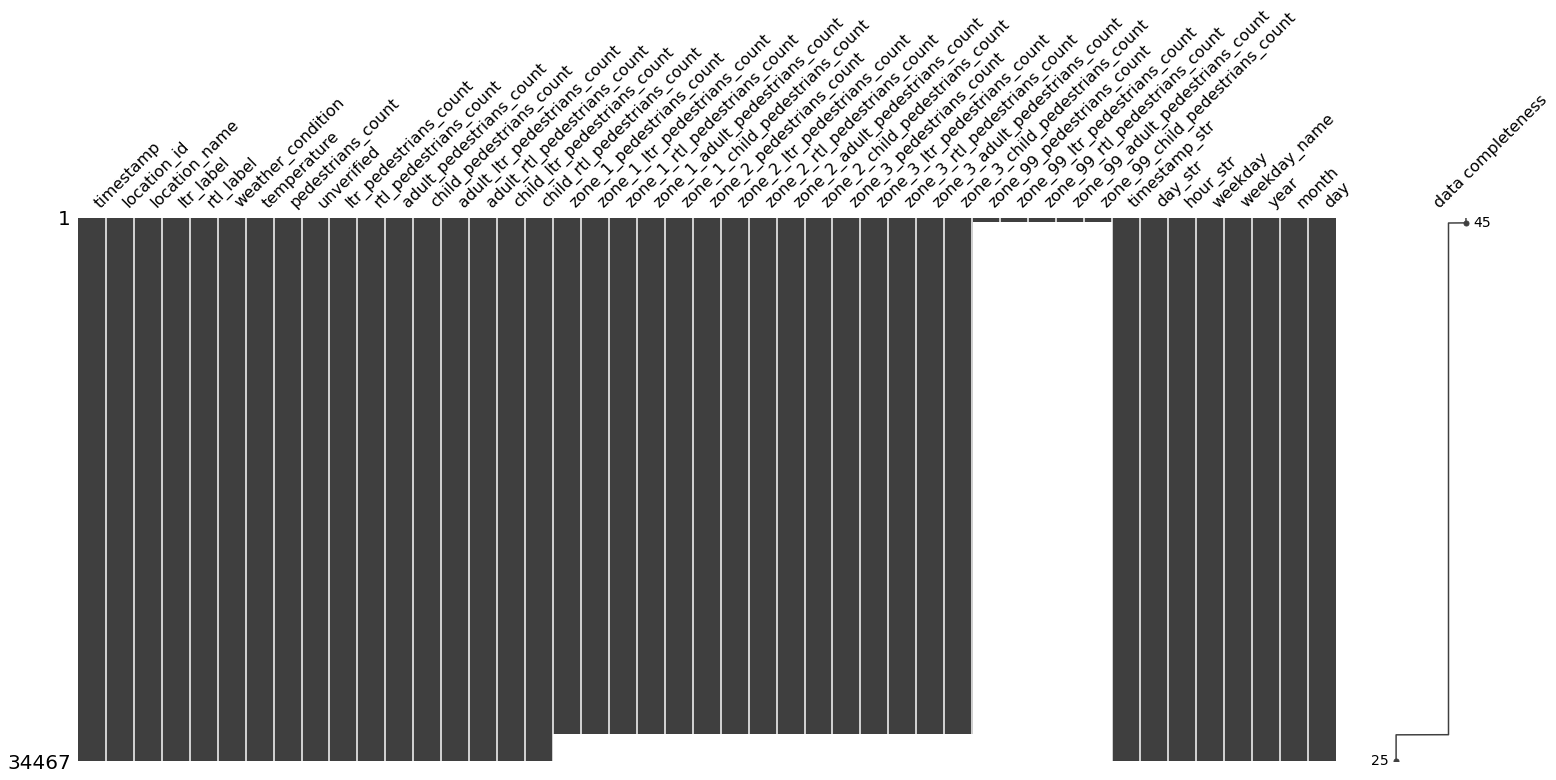

In [29]:
msno.matrix(data2betested, labels=True, sort='descending')

<AxesSubplot:>

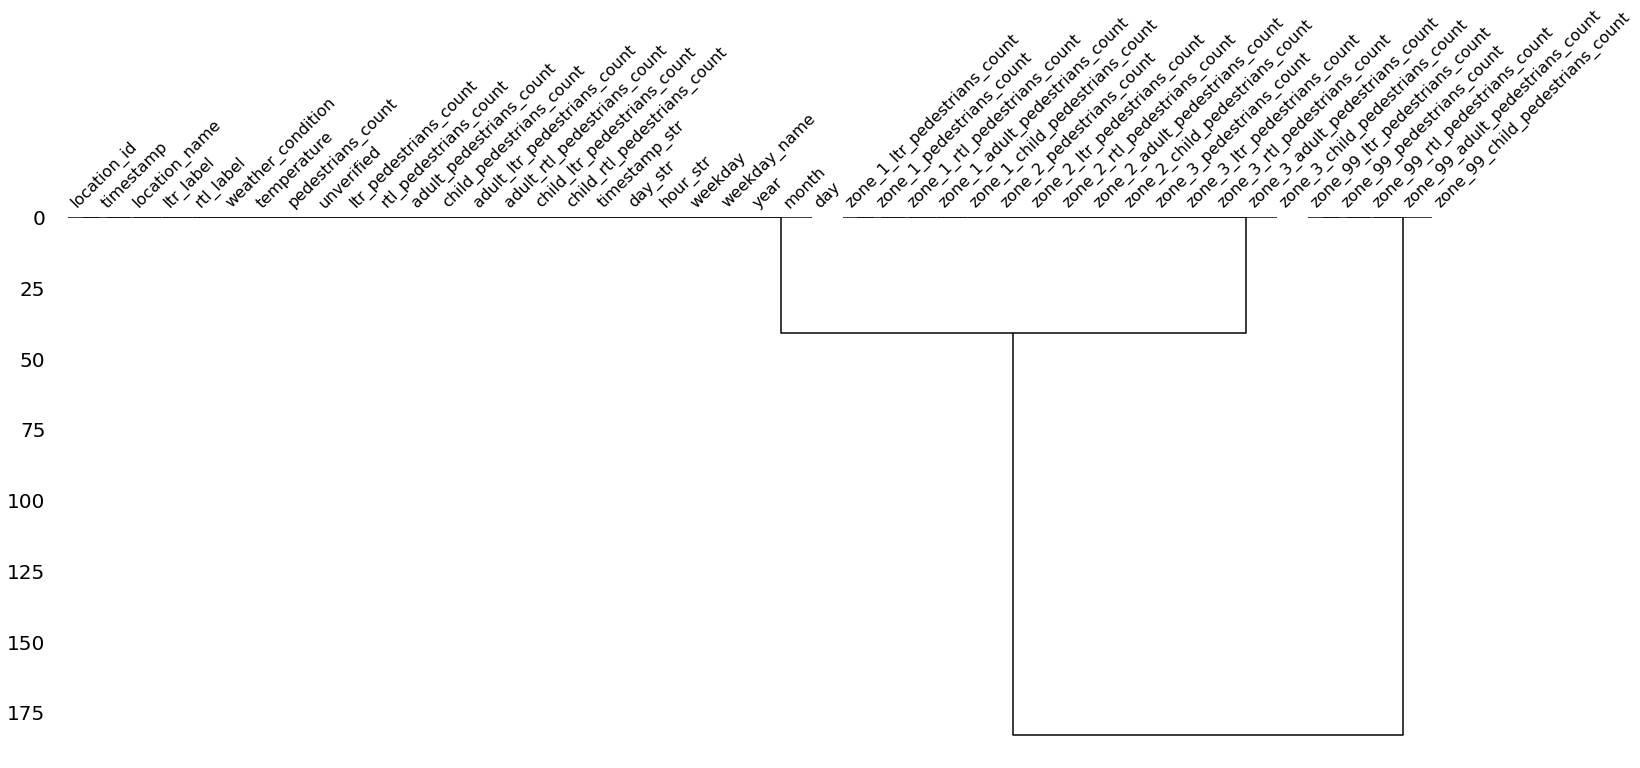

In [30]:
msno.dendrogram(data2betested)

<AxesSubplot:>

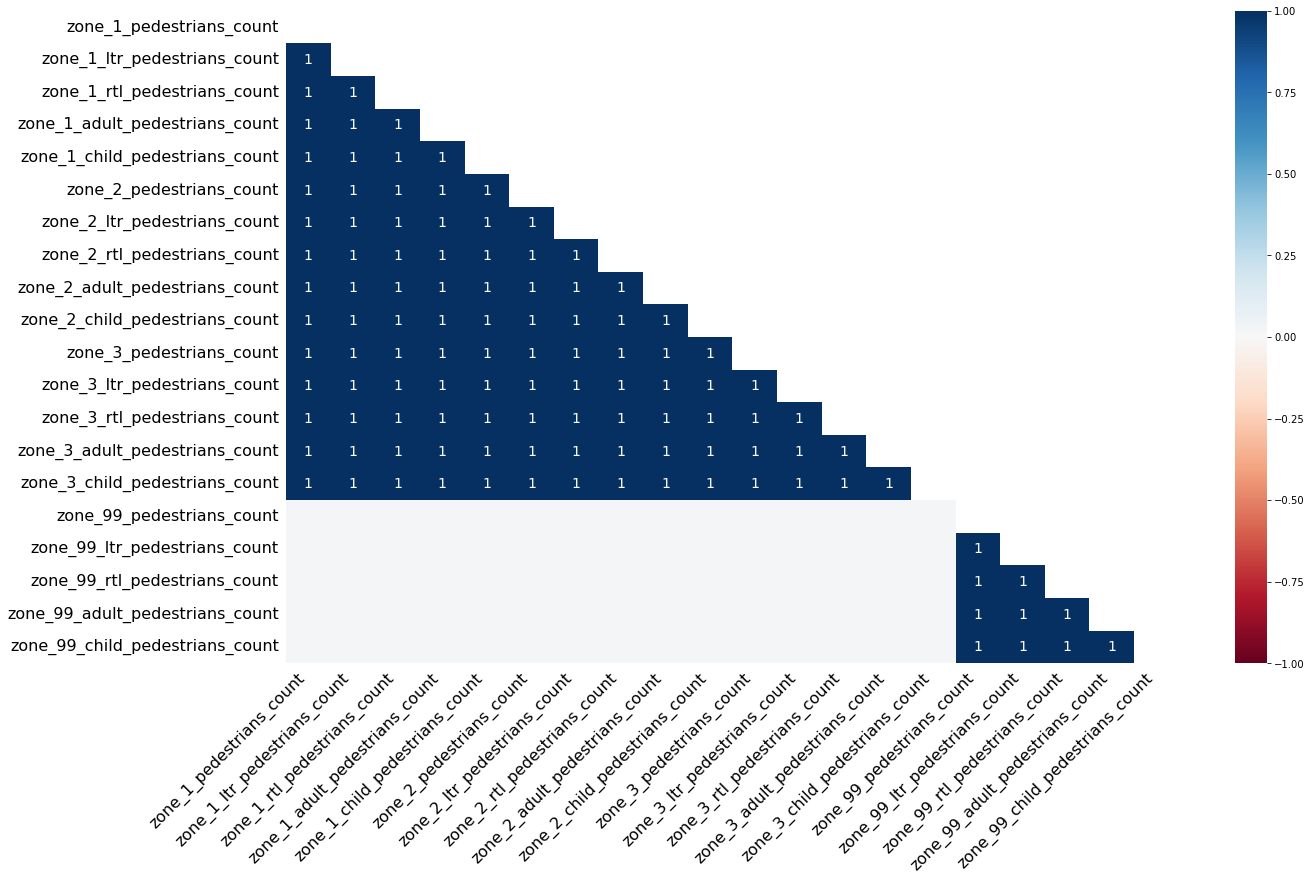

In [31]:
msno.heatmap(data2betested)

Zeige ein Histogramm für jedes numerische Attribut

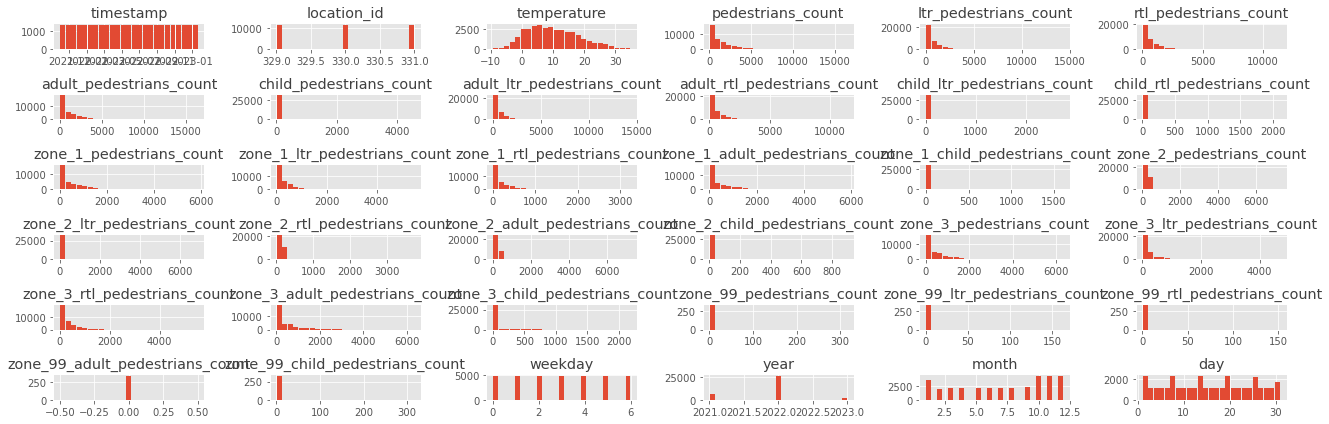

In [32]:
# plot a histogram for each numerical feature
plt.style.use('ggplot')
params = {
    'text.color': (0.25, 0.25, 0.25),
    'figure.figsize': [18, 6],
   }
plt.rcParams.update(params)

try:
    data2betested.hist(bins=25, rwidth=0.9)
    plt.tight_layout()
    plt.show()
except:
    print("No numercial data to plot.") 

### Verwende das Datum als Index

While we did already parse the `datetime` column into the respective datetime type, it currently is just a regular column. 
**To enable quick and convenient queries and aggregations, we need to turn it into the index of the DataFrame**

In [33]:
data2betested = data2betested.set_index("timestamp")

In [34]:
data2betested.info()
data2betested.index.year.unique()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34467 entries, 2023-01-20 14:00:00+00:00 to 2021-09-28 22:00:00+00:00
Data columns (total 44 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   location_id                      34467 non-null  int64  
 1   location_name                    34467 non-null  object 
 2   ltr_label                        34467 non-null  object 
 3   rtl_label                        34467 non-null  object 
 4   weather_condition                34467 non-null  object 
 5   temperature                      34467 non-null  float64
 6   pedestrians_count                34467 non-null  int64  
 7   unverified                       34467 non-null  bool   
 8   ltr_pedestrians_count            34467 non-null  int64  
 9   rtl_pedestrians_count            34467 non-null  int64  
 10  adult_pedestrians_count          34467 non-null  int64  
 11  child_pedestrians_count          

Int64Index([2023, 2022, 2021], dtype='int64', name='timestamp')

### Checke die 99er-Zonen

In [35]:
df_zone99 = data2betested\
    .groupby(['location_name','location_id','ltr_label','rtl_label']) \
    .agg(sum_pedestrians_count=('zone_99_pedestrians_count', 'sum')
         , sum_rtl_pedestrians_count=('zone_99_rtl_pedestrians_count', 'sum')
         , sum_all_pedestrians_count=('zone_99_ltr_pedestrians_count', 'sum')
        )\
    .sort_values('sum_pedestrians_count', ascending=False) 

df_zone99.reset_index().head(6)


location_name  location_id     ltr_label     rtl_label  sum_pedestrians_count  \
0    Bahnhofstrasse (Süd)          330   Bürkliplatz  Hauptbahnhof                    580   
1  Bahnhofstrasse (Mitte)          329  Hauptbahnhof   Bürkliplatz                      0   
2   Bahnhofstrasse (Nord)          331   Bürkliplatz  Hauptbahnhof                      0   

   sum_rtl_pedestrians_count  sum_all_pedestrians_count  
0                        275                        305  
1                          0                          0  
2                          0                          0

### Einfache Visualisierungen zur Plausi

Exploriere die Daten mit Pivottable.JS

In [36]:
from pivottablejs import pivot_ui

pivot_ui(data2betested)

### Zeitpunkte und Zeiträume abfragen

A particular powerful feature of the Pandas DataFrame is its indexing capability that also works using time-based entities, such as dates and times. We have already created the index above, so let's put it to use.

In [37]:
data2betested.loc[date_today].head(2)
#data2betested.loc["2021-10-31":"2021-11-30"].head(2)

location_id          location_name    ltr_label     rtl_label  \
timestamp                                                                                  
2023-01-20 14:00:00+00:00          330   Bahnhofstrasse (Süd)  Bürkliplatz  Hauptbahnhof   
2023-01-20 14:00:00+00:00          331  Bahnhofstrasse (Nord)  Bürkliplatz  Hauptbahnhof   

                           weather_condition  temperature  pedestrians_count  ...  \
timestamp                                                                     ...   
2023-01-20 14:00:00+00:00  partly-cloudy-day            1                  0  ...   
2023-01-20 14:00:00+00:00  partly-cloudy-day            1                  0  ...   

                                    day_str  hour_str  weekday  weekday_name  year  month  day  
timestamp                                                                                       
2023-01-20 14:00:00+00:00  2023-01-20 14:00     14:00        4        Friday  2023      1   20  
2023-01-20 14:00:00+00:00  2023-01-20 14:00     14:00        4        Friday  2023      1   20  

[2 rows x 44 columns]

### Visualisierungen nach Zeitausschnitten

In [38]:
data2betested.columns
#data2betested.dtypes

Index(['location_id', 'location_name', 'ltr_label', 'rtl_label', 'weather_condition',
       'temperature', 'pedestrians_count', 'unverified', 'ltr_pedestrians_count',
       'rtl_pedestrians_count', 'adult_pedestrians_count', 'child_pedestrians_count',
       'adult_ltr_pedestrians_count', 'adult_rtl_pedestrians_count', 'child_ltr_pedestrians_count',
       'child_rtl_pedestrians_count', 'zone_1_pedestrians_count', 'zone_1_ltr_pedestrians_count',
       'zone_1_rtl_pedestrians_count', 'zone_1_adult_pedestrians_count',
       'zone_1_child_pedestrians_count', 'zone_2_pedestrians_count',
       'zone_2_ltr_pedestrians_count', 'zone_2_rtl_pedestrians_count',
       'zone_2_adult_pedestrians_count', 'zone_2_child_pedestrians_count',
       'zone_3_pedestrians_count', 'zone_3_ltr_pedestrians_count', 'zone_3_rtl_pedestrians_count',
       'zone_3_adult_pedestrians_count', 'zone_3_child_pedestrians_count',
       'zone_99_pedestrians_count', 'zone_99_ltr_pedestrians_count',
       'zone_99_r

#### Entwicklung der Fussgängerinnen und Fussgänger an der Bahnhofstrasse

Wöchentliche, tägliche und stündliche Summierungen der Passagierströme

In [39]:
yearly_sums = data2betested[['pedestrians_count','adult_pedestrians_count', 'child_pedestrians_count','ltr_pedestrians_count','rtl_pedestrians_count','zone_1_pedestrians_count','zone_2_pedestrians_count','zone_3_pedestrians_count']].resample("Y").sum()
monthly_sums = data2betested[['pedestrians_count','adult_pedestrians_count', 'child_pedestrians_count','ltr_pedestrians_count','rtl_pedestrians_count','zone_1_pedestrians_count','zone_2_pedestrians_count','zone_3_pedestrians_count']].resample("M").sum()
weekly_sums = data2betested[['pedestrians_count','adult_pedestrians_count', 'child_pedestrians_count','ltr_pedestrians_count','rtl_pedestrians_count','zone_1_pedestrians_count','zone_2_pedestrians_count','zone_3_pedestrians_count']].resample("W").sum()
daily_sums  = data2betested[['pedestrians_count','adult_pedestrians_count', 'child_pedestrians_count','ltr_pedestrians_count','rtl_pedestrians_count','zone_1_pedestrians_count','zone_2_pedestrians_count','zone_3_pedestrians_count']].resample("D").sum()
hourly_sums  = data2betested[['pedestrians_count','adult_pedestrians_count', 'child_pedestrians_count','ltr_pedestrians_count','rtl_pedestrians_count','zone_1_pedestrians_count','zone_2_pedestrians_count','zone_3_pedestrians_count']].resample("H").sum()

#weekly_sums.sort_values('pedestrians_count', ascending=False)
#daily_sums.sort_values('pedestrians_count', ascending=False)
#hourly_sums.sort_values('pedestrians_count', ascending=False)
daily_sums.sort_values('timestamp', ascending=False).head(5)
#monthly_sums.sort_values('pedestrians_count', ascending=False)
yearly_sums.sort_values('timestamp', ascending=False).head(5)
yearly_sums


pedestrians_count  adult_pedestrians_count  child_pedestrians_count  \
timestamp                                                                                        
2021-12-31 00:00:00+00:00            8272870                  6375122                  1897748   
2022-12-31 00:00:00+00:00           27262391                 25776612                  1485779   
2023-12-31 00:00:00+00:00            1457359                  1432898                    24461   

                           ltr_pedestrians_count  rtl_pedestrians_count  zone_1_pedestrians_count  \
timestamp                                                                                           
2021-12-31 00:00:00+00:00                4161779                4111091                   3078279   
2022-12-31 00:00:00+00:00               14044889               13217502                  10593642   
2023-12-31 00:00:00+00:00                 754657                 702702                    549787   

                           zone_2_pedestrians_count  zone_3_pedestrians_count  
timestamp                                                                      
2021-12-31 00:00:00+00:00                   1352094                   3841917  
2022-12-31 00:00:00+00:00                   5354143                  11314606  
2023-12-31 00:00:00+00:00                    292216                    615356

In [40]:
#myAgg = data2betested.loc["2008-11-30":"2021-10-31"]
myAgg = data2betested.loc["2022-06-01":date_today]\
    .groupby(['weekday','weekday_name','weather_condition']) \
    .agg(sum_ltr_pedestrians_count=('ltr_pedestrians_count', 'sum')
         , sum_rtl_pedestrians_count=('rtl_pedestrians_count', 'sum')
         , sum_all_pedestrians_count=('pedestrians_count', 'sum')
        , avg_temp=('temperature', 'mean')
        )\
    .sort_values('sum_ltr_pedestrians_count', ascending=False) 

myAgg.reset_index().head(6)

weekday weekday_name  weather_condition  sum_ltr_pedestrians_count  sum_rtl_pedestrians_count  \
0        5     Saturday          clear-day                     538263                     446669   
1        3     Thursday  partly-cloudy-day                     525737                     498575   
2        5     Saturday  partly-cloudy-day                     484415                     433560   
3        2    Wednesday  partly-cloudy-day                     405361                     378733   
4        4       Friday  partly-cloudy-day                     391173                     361025   
5        0       Monday  partly-cloudy-day                     373087                     345457   

   sum_all_pedestrians_count  avg_temp  
0                     984932        22  
1                    1024312        19  
2                     917975        16  
3                     784094        19  
4                     752198        18  
5                     718544        17

In [41]:
myTitle="Anzahl Passanten nach Wochentag und Wetterverhältnissen "

highlight = alt.selection(type='single', on='mouseover',
                          fields=['sum_ltr_pedestrians_count'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(myAgg.reset_index().query('sum_all_pedestrians_count > 10'), title=myTitle).encode(
    x=alt.X('weekday', axis=alt.Axis(title='Wochentag (0=Mo, 6=So)'))# , axis=alt.Axis(format='%', title='percentage')
    , y=alt.X('sum_all_pedestrians_count', axis=alt.Axis(title='Anzahl Kitas'))
    , color=alt.Color('weather_condition', legend=alt.Legend(title="Anzahl Kitas", orient="right"))  
    ,tooltip=['weekday_name', 'weather_condition']    
)
points = base.mark_circle().encode(
    opacity=alt.value(0.75)
).add_selection(
    highlight
).properties(
    width=750 , height=350
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(0.5), alt.value(4))
).interactive()

lines  + points

alt.LayerChart(...)

In [42]:
data2betested.columns
weekly_sums.columns

Index(['pedestrians_count', 'adult_pedestrians_count', 'child_pedestrians_count',
       'ltr_pedestrians_count', 'rtl_pedestrians_count', 'zone_1_pedestrians_count',
       'zone_2_pedestrians_count', 'zone_3_pedestrians_count'],
      dtype='object')

In [43]:
myTitle="Tagessummen nach Zone"

alt.Chart(daily_sums[['zone_1_pedestrians_count', 'zone_2_pedestrians_count', 'zone_3_pedestrians_count']].loc["2022-08-01":date_today].reset_index().melt("timestamp"), title=myTitle).mark_line(strokeWidth=1).encode(
    x=alt.X('timestamp', axis=alt.Axis(format='', title='Datum'))
    , y=alt.X('value', axis=alt.Axis(title='Anzahl Passanten'))
    , color=alt.Color('variable', legend=alt.Legend(title="Zonen", orient="right"))    
    , tooltip=['variable','value']       
).properties(width=1400, height=400).interactive()

alt.Chart(...)

#### Spezialauswertung Messdaten seit Anfangs Jahr
Evt für die Zahl der Woche

In [44]:
#yearly_sums = data2betested[['pedestrians_count', 'unverified','adult_pedestrians_count', 'child_pedestrians_count']].resample("Y").sum()
daily_sums.sort_values('pedestrians_count',ascending=False)

pedestrians_count  adult_pedestrians_count  child_pedestrians_count  \
timestamp                                                                                        
2022-08-13 00:00:00+00:00             392256                   390113                     2143   
2021-11-27 00:00:00+00:00             176277                   143946                    32331   
2021-12-18 00:00:00+00:00             175701                   142556                    33145   
2021-12-11 00:00:00+00:00             173239                   141944                    31295   
2022-12-31 00:00:00+00:00             164630                   162217                     2413   
...                                      ...                      ...                      ...   
2023-01-15 00:00:00+00:00              27537                    26846                      691   
2022-01-09 00:00:00+00:00              27292                    18985                     8307   
2022-09-25 00:00:00+00:00              27218                    26499                      719   
2022-12-22 00:00:00+00:00              25950                    25199                      751   
2021-09-28 00:00:00+00:00                523                      503                       20   

                           ltr_pedestrians_count  rtl_pedestrians_count  zone_1_pedestrians_count  \
timestamp                                                                                           
2022-08-13 00:00:00+00:00                 217743                 174513                    143584   
2021-11-27 00:00:00+00:00                  90558                  85719                     67562   
2021-12-18 00:00:00+00:00                  90461                  85240                     69895   
2021-12-11 00:00:00+00:00                  88802                  84437                     67268   
2022-12-31 00:00:00+00:00                  91701                  72929                     66797   
...                                          ...                    ...                       ...   
2023-01-15 00:00:00+00:00                  14179                  13358                     10128   
2022-01-09 00:00:00+00:00                  13659                  13633                      9806   
2022-09-25 00:00:00+00:00                  14004                  13214                     10022   
2022-12-22 00:00:00+00:00                  12721                  13229                      8254   
2021-09-28 00:00:00+00:00                    205                    318                       104   

                           zone_2_pedestrians_count  zone_3_pedestrians_count  
timestamp                                                                      
2022-08-13 00:00:00+00:00                    121274                    127398  
2021-11-27 00:00:00+00:00                     19062                     89653  
2021-12-18 00:00:00+00:00                     19126                     86680  
2021-12-11 00:00:00+00:00                     19347                     86624  
2022-12-31 00:00:00+00:00                     28418                     69415  
...                                             ...                       ...  
2023-01-15 00:00:00+00:00                      6632                     10777  
2022-01-09 00:00:00+00:00                      6240                     11246  
2022-09-25 00:00:00+00:00                      5639                     11557  
2022-12-22 00:00:00+00:00                      6645                     11051  
2021-09-28 00:00:00+00:00                       240                       179  

[480 rows x 8 columns]

Die Summation betrachtet die Variable `unverified` nicht. Daher ist nicht klar, ob diese Aussage genügt. Im Folgenden mache ich eine Aggregation.

In [45]:
#data2betested.columns
data2betested.reset_index().sort_values('timestamp', ascending=False).head(10)

timestamp  location_id           location_name     ltr_label     rtl_label  \
0 2023-01-20 14:00:00+00:00          330    Bahnhofstrasse (Süd)   Bürkliplatz  Hauptbahnhof   
2 2023-01-20 14:00:00+00:00          329  Bahnhofstrasse (Mitte)  Hauptbahnhof   Bürkliplatz   
1 2023-01-20 14:00:00+00:00          331   Bahnhofstrasse (Nord)   Bürkliplatz  Hauptbahnhof   
3 2023-01-20 13:00:00+00:00          330    Bahnhofstrasse (Süd)   Bürkliplatz  Hauptbahnhof   
5 2023-01-20 13:00:00+00:00          329  Bahnhofstrasse (Mitte)  Hauptbahnhof   Bürkliplatz   
4 2023-01-20 13:00:00+00:00          331   Bahnhofstrasse (Nord)   Bürkliplatz  Hauptbahnhof   
6 2023-01-20 12:00:00+00:00          330    Bahnhofstrasse (Süd)   Bürkliplatz  Hauptbahnhof   
8 2023-01-20 12:00:00+00:00          329  Bahnhofstrasse (Mitte)  Hauptbahnhof   Bürkliplatz   
7 2023-01-20 12:00:00+00:00          331   Bahnhofstrasse (Nord)   Bürkliplatz  Hauptbahnhof   
9 2023-01-20 11:00:00+00:00          330    Bahnhofstrasse (Süd)   Bürkliplatz  Hauptbahnhof   

   weather_condition  temperature  ...           day_str  hour_str  weekday  weekday_name  year  \
0  partly-cloudy-day            1  ...  2023-01-20 14:00     14:00        4        Friday  2023   
2  partly-cloudy-day            1  ...  2023-01-20 14:00     14:00        4        Friday  2023   
1  partly-cloudy-day            1  ...  2023-01-20 14:00     14:00        4        Friday  2023   
3  partly-cloudy-day            1  ...  2023-01-20 13:00     13:00        4        Friday  2023   
5  partly-cloudy-day            1  ...  2023-01-20 13:00     13:00        4        Friday  2023   
4  partly-cloudy-day            1  ...  2023-01-20 13:00     13:00        4        Friday  2023   
6  partly-cloudy-day           -0  ...  2023-01-20 12:00     12:00        4        Friday  2023   
8  partly-cloudy-day           -0  ...  2023-01-20 12:00     12:00        4        Friday  2023   
7  partly-cloudy-day           -0  ...  2023-01-20 12:00     12:00        4        Friday  2023   
9  partly-cloudy-day           -1  ...  2023-01-20 11:00     11:00        4        Friday  2023   

   month  day  
0      1   20  
2      1   20  
1      1   20  
3      1   20  
5      1   20  
4      1   20  
6      1   20  
8      1   20  
7      1   20  
9      1   20  

[10 rows x 45 columns]

In [46]:
#aggYearlySums = data2betested.loc["2022-01-01":date_today]\
#    .groupby(['year','location_id','location_name', 'unverified']) \

aggYearlySums = data2betested\
    .groupby(['year']) \
    .agg(sum_all_pedestrians_count=('pedestrians_count', 'sum')
         , sum_ltr_pedestrians_count=('ltr_pedestrians_count', 'sum')
         , sum_rtl_pedestrians_count=('rtl_pedestrians_count', 'sum')
        , avg_temp=('temperature', 'mean')
        )\
    .sort_values('year', ascending=False) 

aggYearlySums.reset_index().head(6)

year  sum_all_pedestrians_count  sum_ltr_pedestrians_count  sum_rtl_pedestrians_count  avg_temp
0  2023                    1457359                     754657                     702702         5
1  2022                   27262391                   14044889                   13217502        11
2  2021                    8272870                    4161779                    4111091         5

Die unverifizierten Zählungen machen nur einen sehr sehr geringen Wert aus. Daher kann wohl auch mit den resamples gearbeitet werden.

#### Spezialauswertung Messdaten zu ausgewählten Zeitpunkten
Evt für die Zahl der Woche

In [47]:
data2betested.columns
hourly_sums.columns

Index(['pedestrians_count', 'adult_pedestrians_count', 'child_pedestrians_count',
       'ltr_pedestrians_count', 'rtl_pedestrians_count', 'zone_1_pedestrians_count',
       'zone_2_pedestrians_count', 'zone_3_pedestrians_count'],
      dtype='object')

In [48]:
myTitle="Stundensummen an der Streetparade nach Zone"

alt.Chart(hourly_sums[['pedestrians_count','zone_1_pedestrians_count', 'zone_2_pedestrians_count', 'zone_3_pedestrians_count']].loc["2022-12-01 03":date_today].reset_index().melt("timestamp"), title=myTitle).mark_line(strokeWidth=1).encode(
    x=alt.X('timestamp', axis=alt.Axis(format='', title='Datum'))
    , y=alt.X('value', axis=alt.Axis(title='Anzahl Passanten'))
    , color=alt.Color('variable', legend=alt.Legend(title="Zonen", orient="right"))    
    , tooltip=['variable','value']       
).properties(width=1000, height=400).interactive()

alt.Chart(...)

#### Barcharts mit Seaborn

In [49]:
#myAgg = data2betested.loc["2008-11-30":"2021-10-31"]
myAggBar = data2betested.loc["2022-06-01":date_today]\
    .groupby(['weekday','weekday_name','weather_condition']) \
    .agg(sum_ltr_pedestrians_count=('ltr_pedestrians_count', 'sum')
         , sum_rtl_pedestrians_count=('rtl_pedestrians_count', 'sum')
         , sum_all_pedestrians_count=('pedestrians_count', 'sum')
        , avg_temp=('temperature', 'mean')
        )\
    .sort_values('sum_ltr_pedestrians_count', ascending=False) 

myAggBar.reset_index().head(6)

weekday weekday_name  weather_condition  sum_ltr_pedestrians_count  sum_rtl_pedestrians_count  \
0        5     Saturday          clear-day                     538263                     446669   
1        3     Thursday  partly-cloudy-day                     525737                     498575   
2        5     Saturday  partly-cloudy-day                     484415                     433560   
3        2    Wednesday  partly-cloudy-day                     405361                     378733   
4        4       Friday  partly-cloudy-day                     391173                     361025   
5        0       Monday  partly-cloudy-day                     373087                     345457   

   sum_all_pedestrians_count  avg_temp  
0                     984932        22  
1                    1024312        19  
2                     917975        16  
3                     784094        19  
4                     752198        18  
5                     718544        17

In [50]:
#help(sns.catplot)     
#data2betested.columns

In [51]:
#Stile for the following sns graphs
sns.set_theme(style="whitegrid")

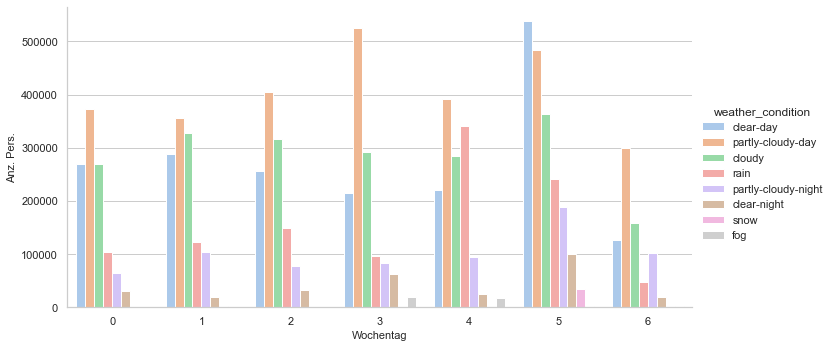

In [52]:
#sns.color_palette("flare", as_cmap=True)
myHist = sns.catplot(x="weekday"
            , y="sum_ltr_pedestrians_count"
            , hue="weather_condition"
            , kind="bar" #boxen, violin, --> wenn die aggregation nicht genau den werten in der grafik entspricht
            , palette="pastel" #, color="green"
            , height=5
            , aspect=2
            , order=None, legend_out=True
            ,data=myAggBar.reset_index()
           )
myHist.set_xticklabels(rotation=0) 
myHist.set_xlabels('Wochentag', fontsize=11) # not set_label
myHist.set_ylabels('Anz. Pers.', fontsize=11)


In [53]:
#data2betested.columns
#data2betested.dtypes
#data2betested.groupby(['unverified']).agg(test=('unverified', 'count'))

In [54]:
#myAgg = data2betested.loc["2022-01-01":date_today].query('unverified == True')\

myAggBar = data2betested.loc["2022-09-30 03":date_today]\
    .groupby(['location_id', 'location_name','ltr_label', 'rtl_label']) \
    .agg(sum_ltr_pedestrians_count=('ltr_pedestrians_count', 'sum')
         , sum_rtl_pedestrians_count=('rtl_pedestrians_count', 'sum')
         , sum_all_pedestrians_count=('pedestrians_count', 'sum')
        , avg_temp=('temperature', 'mean')
        , sum_adult_pedestrians_count=('adult_pedestrians_count', 'sum')
         , sum_child_pedestrians_count=('child_pedestrians_count', 'sum')         
        )\
    .sort_values('sum_ltr_pedestrians_count', ascending=False) 

myAggBar.reset_index().head(3)

location_id           location_name     ltr_label     rtl_label  sum_ltr_pedestrians_count  \
0          329  Bahnhofstrasse (Mitte)  Hauptbahnhof   Bürkliplatz                    2261711   
1          330    Bahnhofstrasse (Süd)   Bürkliplatz  Hauptbahnhof                    1197672   
2          331   Bahnhofstrasse (Nord)   Bürkliplatz  Hauptbahnhof                     467668   

   sum_rtl_pedestrians_count  sum_all_pedestrians_count  avg_temp  sum_adult_pedestrians_count  \
0                    2106452                    4368163         7                      4299244   
1                    1182223                    2379895         7                      2304895   
2                     402307                     869975         7                       862670   

   sum_child_pedestrians_count  
0                        68919  
1                        75000  
2                         7305

In [55]:
monthly_sums.reset_index().columns

Index(['timestamp', 'pedestrians_count', 'adult_pedestrians_count', 'child_pedestrians_count',
       'ltr_pedestrians_count', 'rtl_pedestrians_count', 'zone_1_pedestrians_count',
       'zone_2_pedestrians_count', 'zone_3_pedestrians_count'],
      dtype='object')

In [56]:
#aktuell nimmt die Zeitreihe nicht das laufende Jahr auf.

#days_tb = df_zeitreihe_tb.loc["2017-01-01 00:00":"2021-12-31 00:00"].dropna(axis=1).resample("D").median()
#months_tb =df_zeitreihe_tb[['air_temperature','water_temperature']].dropna(axis=1).loc["2017-01-01 00:00":"2021-12-31 00:00"].resample("M").median()


brush = alt.selection(type='interval', encodings=['x'])

upper = alt.Chart(weekly_sums[['zone_1_pedestrians_count', 'zone_2_pedestrians_count', 'zone_3_pedestrians_count']].loc["2021-12":date_today].reset_index().melt("timestamp")).mark_area(interpolate="basis").encode(
    x = alt.X('timestamp:T', axis=None),
    y = alt.Y('value:Q', axis=None),
    color='variable'
).properties(width=1000, height=100).add_selection(brush)

lower = alt.Chart(daily_sums[['pedestrians_count','zone_1_pedestrians_count', 'zone_2_pedestrians_count', 'zone_3_pedestrians_count']].loc["2021-12":date_today].reset_index().melt("timestamp")).mark_line(strokeWidth=1).encode(
    x = alt.X('timestamp:T', scale=alt.Scale(domain=brush)),
    y='value',
    color='variable',
).properties(width=1000, height=400)

upper & lower

alt.VConcatChart(...)

In [57]:
data2betested.reset_index().columns

Index(['timestamp', 'location_id', 'location_name', 'ltr_label', 'rtl_label', 'weather_condition',
       'temperature', 'pedestrians_count', 'unverified', 'ltr_pedestrians_count',
       'rtl_pedestrians_count', 'adult_pedestrians_count', 'child_pedestrians_count',
       'adult_ltr_pedestrians_count', 'adult_rtl_pedestrians_count', 'child_ltr_pedestrians_count',
       'child_rtl_pedestrians_count', 'zone_1_pedestrians_count', 'zone_1_ltr_pedestrians_count',
       'zone_1_rtl_pedestrians_count', 'zone_1_adult_pedestrians_count',
       'zone_1_child_pedestrians_count', 'zone_2_pedestrians_count',
       'zone_2_ltr_pedestrians_count', 'zone_2_rtl_pedestrians_count',
       'zone_2_adult_pedestrians_count', 'zone_2_child_pedestrians_count',
       'zone_3_pedestrians_count', 'zone_3_ltr_pedestrians_count', 'zone_3_rtl_pedestrians_count',
       'zone_3_adult_pedestrians_count', 'zone_3_child_pedestrians_count',
       'zone_99_pedestrians_count', 'zone_99_ltr_pedestrians_count',
    

In [58]:
#.loc["2022-01-01":"2022-04-01"]
#.loc["2022-01-01":date_today]
#.groupby(['timestamp','location_id', 'location_name','ltr_label', 'rtl_label']) \

myAggBar2 = data2betested.loc["2022-08-01":date_today].reset_index()\
    .groupby(['timestamp','location_id', 'location_name']) \
    .agg(sum_all_pedestrians_count=('pedestrians_count', 'sum')
         , sum_ltr_pedestrians_count=('ltr_pedestrians_count', 'sum')
         , sum_rtl_pedestrians_count=('rtl_pedestrians_count', 'sum')
        , avg_temp=('temperature', 'mean')
        , sum_adult_pedestrians_count=('adult_pedestrians_count', 'sum')
         , sum_child_pedestrians_count=('child_pedestrians_count', 'sum')         
        )\
    .sort_values('timestamp', ascending=False) 
myAggBar2.head(15)


sum_all_pedestrians_count  \
timestamp                 location_id location_name                                       
2023-01-20 14:00:00+00:00 331         Bahnhofstrasse (Nord)                           0   
                          330         Bahnhofstrasse (Süd)                            0   
                          329         Bahnhofstrasse (Mitte)                          0   
2023-01-20 13:00:00+00:00 331         Bahnhofstrasse (Nord)                        1541   
                          330         Bahnhofstrasse (Süd)                         1150   
                          329         Bahnhofstrasse (Mitte)                       2095   
2023-01-20 12:00:00+00:00 331         Bahnhofstrasse (Nord)                        2110   
                          330         Bahnhofstrasse (Süd)                         1570   
                          329         Bahnhofstrasse (Mitte)                       3339   
2023-01-20 11:00:00+00:00 329         Bahnhofstrasse (Mitte)                       3018   
                          330         Bahnhofstrasse (Süd)                         1559   
                          331         Bahnhofstrasse (Nord)                        1955   
2023-01-20 10:00:00+00:00 331         Bahnhofstrasse (Nord)                        1390   
                          330         Bahnhofstrasse (Süd)                         1226   
                          329         Bahnhofstrasse (Mitte)                       2165   

                                                              sum_ltr_pedestrians_count  \
timestamp                 location_id location_name                                       
2023-01-20 14:00:00+00:00 331         Bahnhofstrasse (Nord)                           0   
                          330         Bahnhofstrasse (Süd)                            0   
                          329         Bahnhofstrasse (Mitte)                          0   
2023-01-20 13:00:00+00:00 331         Bahnhofstrasse (Nord)                         855   
                          330         Bahnhofstrasse (Süd)                          568   
                          329         Bahnhofstrasse (Mitte)                       1172   
2023-01-20 12:00:00+00:00 331         Bahnhofstrasse (Nord)                        1176   
                          330         Bahnhofstrasse (Süd)                          888   
                          329         Bahnhofstrasse (Mitte)                       1662   
2023-01-20 11:00:00+00:00 329         Bahnhofstrasse (Mitte)                       1493   
                          330         Bahnhofstrasse (Süd)                          739   
                          331         Bahnhofstrasse (Nord)                        1173   
2023-01-20 10:00:00+00:00 331         Bahnhofstrasse (Nord)                         836   
                          330         Bahnhofstrasse (Süd)                          579   
                          329         Bahnhofstrasse (Mitte)                       1155   

                                                              sum_rtl_pedestrians_count  avg_temp  \
timestamp                 location_id location_name                                                 
2023-01-20 14:00:00+00:00 331         Bahnhofstrasse (Nord)                           0         1   
                          330         Bahnhofstrasse (Süd)                            0         1   
                          329         Bahnhofstrasse (Mitte)                          0         1   
2023-01-20 13:00:00+00:00 331         Bahnhofstrasse (Nord)                         686         1   
                          330         Bahnhofstrasse (Süd)                          582         1   
                          329         Bahnhofstrasse (Mitte)                        923         1   
2023-01-20 12:00:00+00:00 331         Bahnhofstrasse (Nord)                         934        -0   
                          330         Bahnhofstrasse (Süd

In [59]:
myAggBar2 = myAggBar2.reset_index()
myAggBar2.columns
#myAggBar2

Index(['timestamp', 'location_id', 'location_name', 'sum_all_pedestrians_count',
       'sum_ltr_pedestrians_count', 'sum_rtl_pedestrians_count', 'avg_temp',
       'sum_adult_pedestrians_count', 'sum_child_pedestrians_count'],
      dtype='object')

In [60]:
myTitle="Anzahl Passanten nach Teilgebiet"

highlight = alt.selection(type='single', on='mouseover',
                          fields=['sum_all_pedestrians_count'], nearest=True)
#x='date:StichtagDatJahr',
base = alt.Chart(myAggBar2.reset_index().query('location_name == "Bahnhofstrasse (Süd)"'), title=myTitle).encode(
    x=alt.X('timestamp:T', axis=alt.Axis(title='Zeit'))# , axis=alt.Axis(format='%', title='percentage')
    , y=alt.X('sum_all_pedestrians_count', axis=alt.Axis(title='Anzahl Passanten total'))
    , color=alt.Color('location_name', legend=alt.Legend(title="Teilgebiet", orient="right"))  
    ,tooltip=['timestamp','location_id','location_name','sum_all_pedestrians_count']    
)

points = base.mark_circle().encode(
    opacity=alt.value(0.55)
).add_selection(
    highlight
).properties(
    width=1450 , height=350
)
lines = base.mark_line().encode(
    size=alt.condition(~highlight, alt.value(1.5), alt.value(4))
).interactive()


lines  + points

alt.LayerChart(...)

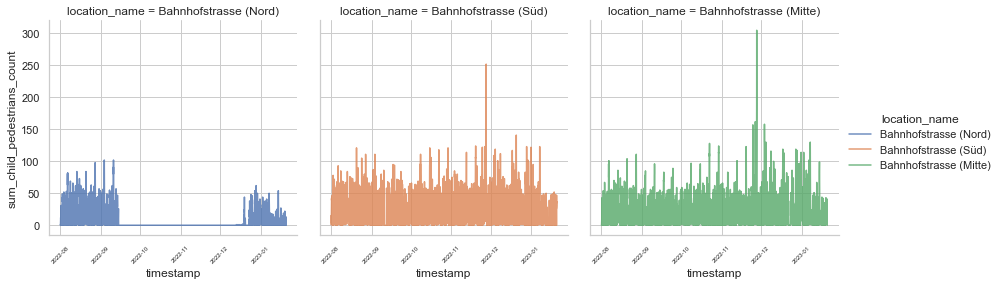

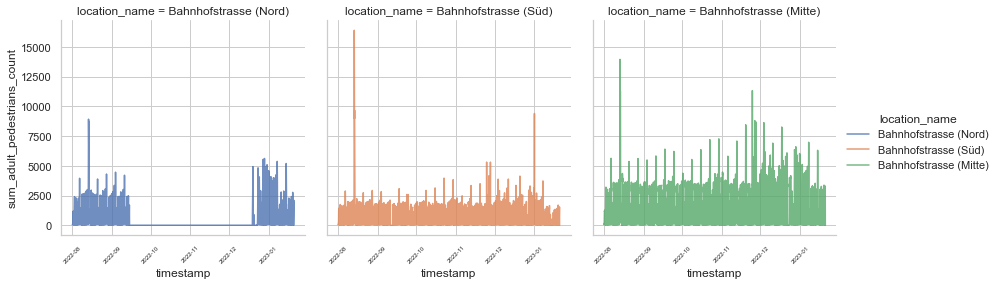

In [61]:
#g = sns.FacetGrid(myAggBar.reset_index(), col="QuarLang", hue="HerkunftLang", col_wrap=6, height=3,)
#g.map(sns.scatterplot, "AlterV05Sort", "sum_WBev", alpha=.8)
#g.add_legend()

g2 = sns.FacetGrid(myAggBar2.reset_index(), col="location_name", hue="location_name", col_wrap=3, height=4,)
g2.map(sns.lineplot, "timestamp","sum_child_pedestrians_count",alpha=.8)

g2.set_xticklabels(rotation=45, fontsize=6) 
g2.add_legend()

g3 = sns.FacetGrid(myAggBar2.reset_index(), col="location_name", hue="location_name", col_wrap=3, height=4,)
g3.map(sns.lineplot, "timestamp","sum_adult_pedestrians_count",alpha=.8)
#g2.map(sns.lineplot, "timestamp","sum_adult_pedestrians_count",alpha=.8)

g3.set_xticklabels(rotation=45, fontsize=6) 
g3.add_legend()

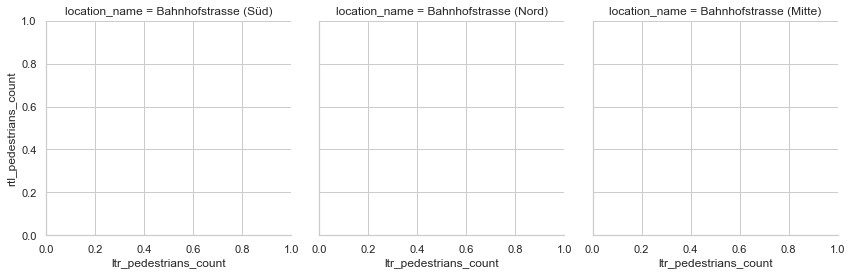

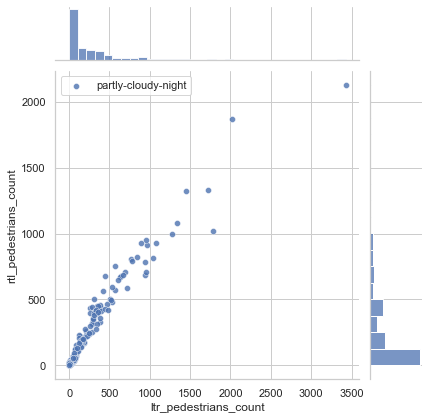

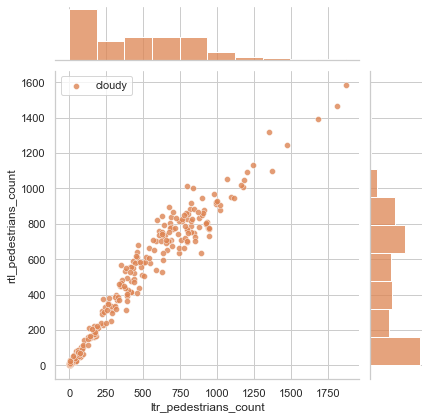

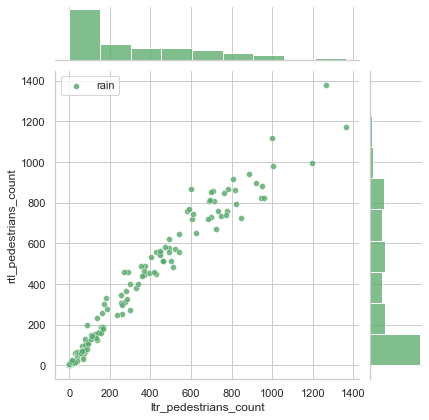

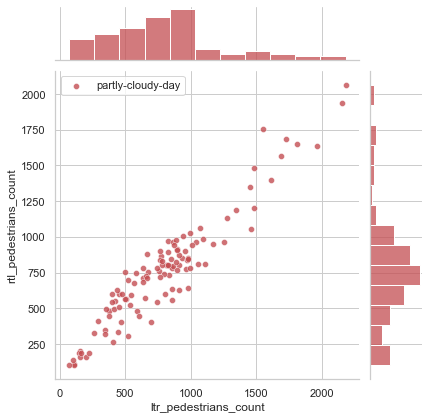

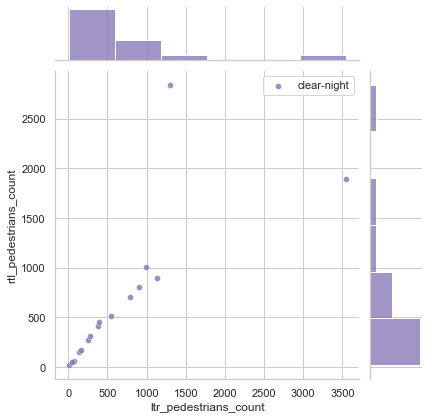

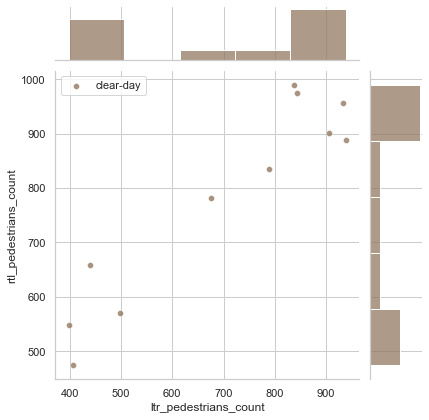

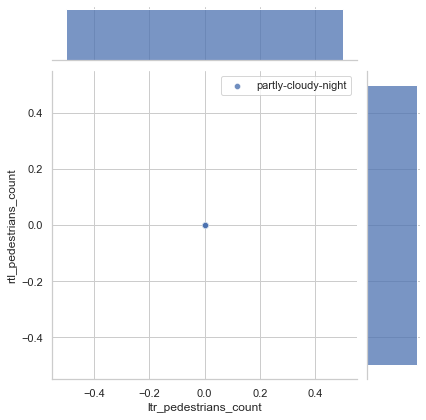

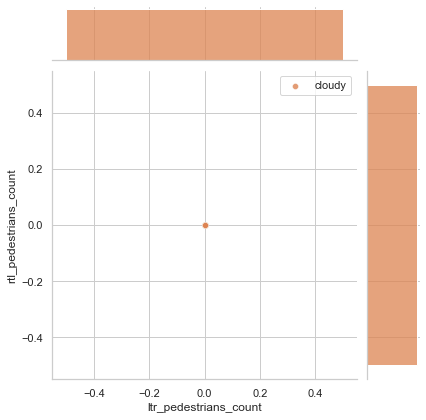

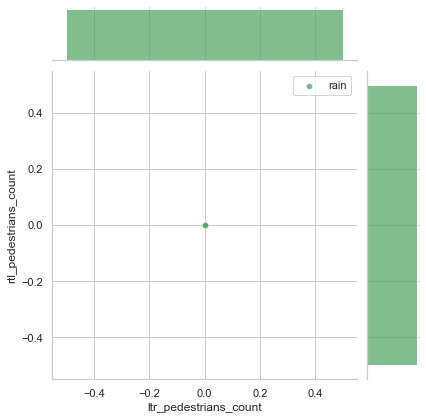

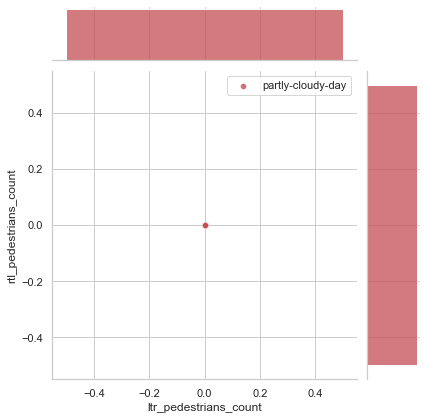

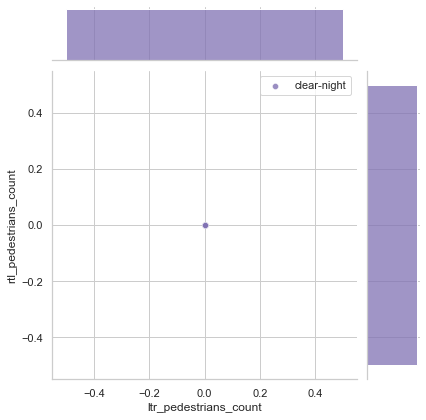

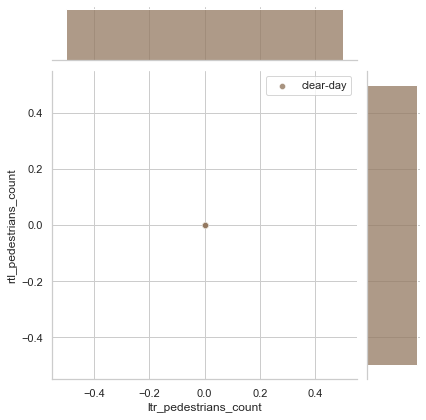

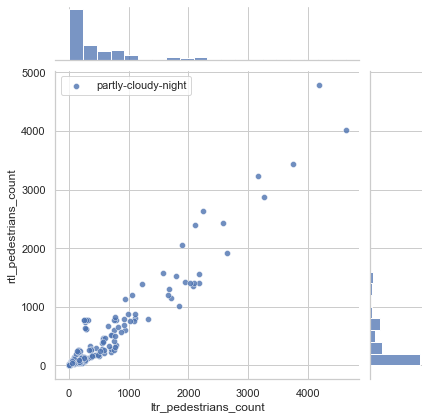

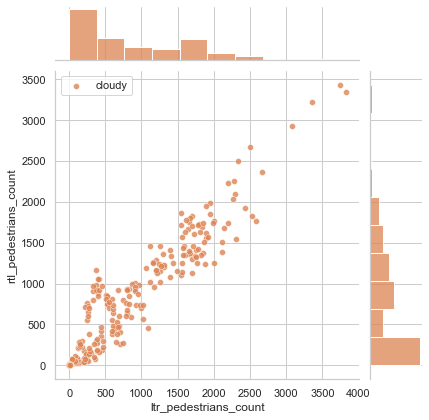

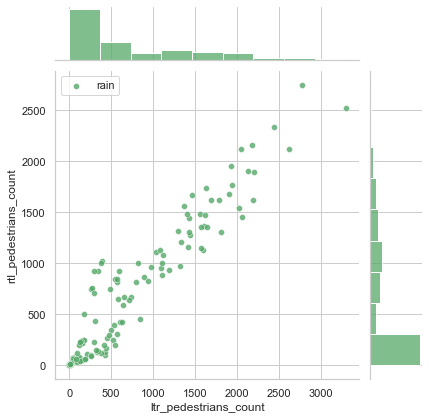

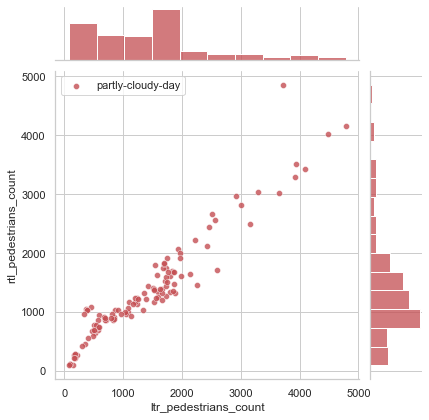

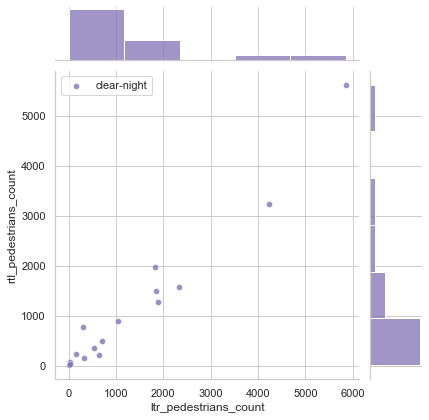

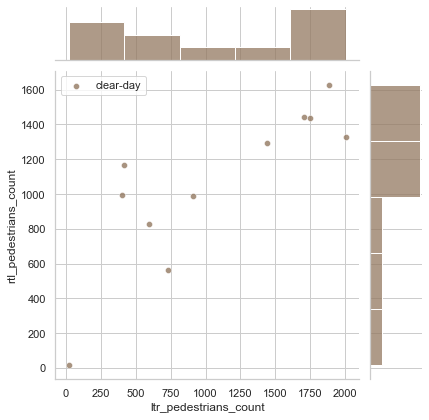

In [62]:
g4 = sns.FacetGrid(data2betested.loc["2022-11"].reset_index(),col="location_name",  hue="weather_condition", col_wrap=3, height=4,)
g4.map(sns.jointplot, "ltr_pedestrians_count", "rtl_pedestrians_count",alpha=.8)

#sns.jointplot(data=data2betested.loc["2022-07"].reset_index(), x="ltr_pedestrians_count", y="rtl_pedestrians_count", hue="weather_condition")
#sns.jointplot(data=data2betested.loc["2022-07"].reset_index(), x="ltr_pedestrians_count", y="rtl_pedestrians_count", hue="location_name")

### Daten in interaktiver Treemap zeigen
Dazu gibt es eine sehr nützliche Webseite https://plotly.com/python/treemaps/
Zu Farbskalen, siehe: https://plotly.com/python/builtin-colorscales/

#### Aktueller Bestand der WBev nach Quartier, Herkunft und Geschlecht

In [63]:
data2betested.columns
#data2betested

Index(['location_id', 'location_name', 'ltr_label', 'rtl_label', 'weather_condition',
       'temperature', 'pedestrians_count', 'unverified', 'ltr_pedestrians_count',
       'rtl_pedestrians_count', 'adult_pedestrians_count', 'child_pedestrians_count',
       'adult_ltr_pedestrians_count', 'adult_rtl_pedestrians_count', 'child_ltr_pedestrians_count',
       'child_rtl_pedestrians_count', 'zone_1_pedestrians_count', 'zone_1_ltr_pedestrians_count',
       'zone_1_rtl_pedestrians_count', 'zone_1_adult_pedestrians_count',
       'zone_1_child_pedestrians_count', 'zone_2_pedestrians_count',
       'zone_2_ltr_pedestrians_count', 'zone_2_rtl_pedestrians_count',
       'zone_2_adult_pedestrians_count', 'zone_2_child_pedestrians_count',
       'zone_3_pedestrians_count', 'zone_3_ltr_pedestrians_count', 'zone_3_rtl_pedestrians_count',
       'zone_3_adult_pedestrians_count', 'zone_3_child_pedestrians_count',
       'zone_99_pedestrians_count', 'zone_99_ltr_pedestrians_count',
       'zone_99_r

In [64]:
data2betested[['location_id', 'location_name', 'ltr_label', 'rtl_label', 'weather_condition','temperature', 'pedestrians_count', 'unverified', 'ltr_pedestrians_count'
               ,'rtl_pedestrians_count', 'adult_pedestrians_count', 'child_pedestrians_count']]\
.query('location_name=="Bahnhofstrasse (Nord)"').head(30)

location_id          location_name    ltr_label     rtl_label  \
timestamp                                                                                  
2023-01-20 14:00:00+00:00          331  Bahnhofstrasse (Nord)  Bürkliplatz  Hauptbahnhof   
2023-01-20 13:00:00+00:00          331  Bahnhofstrasse (Nord)  Bürkliplatz  Hauptbahnhof   
2023-01-20 12:00:00+00:00          331  Bahnhofstrasse (Nord)  Bürkliplatz  Hauptbahnhof   
2023-01-20 11:00:00+00:00          331  Bahnhofstrasse (Nord)  Bürkliplatz  Hauptbahnhof   
2023-01-20 10:00:00+00:00          331  Bahnhofstrasse (Nord)  Bürkliplatz  Hauptbahnhof   
2023-01-20 09:00:00+00:00          331  Bahnhofstrasse (Nord)  Bürkliplatz  Hauptbahnhof   
2023-01-20 08:00:00+00:00          331  Bahnhofstrasse (Nord)  Bürkliplatz  Hauptbahnhof   
2023-01-20 07:00:00+00:00          331  Bahnhofstrasse (Nord)  Bürkliplatz  Hauptbahnhof   
2023-01-20 06:00:00+00:00          331  Bahnhofstrasse (Nord)  Bürkliplatz  Hauptbahnhof   
2023-01-20 05:00:00+00:00          331  Bahnhofstrasse (Nord)  Bürkliplatz  Hauptbahnhof   
2023-01-20 04:00:00+00:00          331  Bahnhofstrasse (Nord)  Bürkliplatz  Hauptbahnhof   
2023-01-20 03:00:00+00:00          331  Bahnhofstrasse (Nord)  Bürkliplatz  Hauptbahnhof   
2023-01-20 02:00:00+00:00          331  Bahnhofstrasse (Nord)  Bürkliplatz  Hauptbahnhof   
2023-01-20 01:00:00+00:00          331  Bahnhofstrasse (Nord)  Bürkliplatz  Hauptbahnhof   
2023-01-20 00:00:00+00:00          331  Bahnhofstrasse (Nord)  Bürkliplatz  Hauptbahnhof   
2023-01-19 23:00:00+00:00          331  Bahnhofstrasse (Nord)  Bürkliplatz  Hauptbahnhof   
2023-01-19 22:00:00+00:00          331  Bahnhofstrasse (Nord)  Bürkliplatz  Hauptbahnhof   
2023-01-19 21:00:00+00:00          331  Bahnhofstrasse (Nord)  Bürkliplatz  Hauptbahnhof   
2023-01-19 20:00:00+00:00          331  Bahnhofstrasse (Nord)  Bürkliplatz  Hauptbahnhof   
2023-01-19 19:00:00+00:00          331  Bahnhofstrasse (Nord)  Bürkliplatz  Hauptbahnhof   
2023-01-19 18:00:00+00:00          331  Bahnhofstrasse (Nord)  Bürkliplatz  Hauptbahnhof   
2023-01-19 17:00:00+00:00          331  Bahnhofstrasse (Nord)  Bürkliplatz  Hauptbahnhof   
2023-01-19 16:00:00+00:00          331  Bahnhofstrasse (Nord)  Bürkliplatz  Hauptbahnhof   
2023-01-19 15:00:00+00:00          331  Bahnhofstrasse (Nord)  Bürkliplatz  Hauptbahnhof   
2023-01-19 14:00:00+00:00          331  Bahnhofstrasse (Nord)  Bürkliplatz  Hauptbahnhof   
2023-01-19 13:00:00+00:00          331  Bahnhofstrasse (Nord)  Bürkliplatz  Hauptbahnhof   
2023-01-19 12:00:00+00:00          331  Bahnhofstrasse (Nord)  Bürkliplatz  Hauptbahnhof   
2023-01-19 11:00:00+00:00          331  Bahnhofstrasse (Nord)  Bürkliplatz  Hauptbahnhof   
2023-01-19 10:00:00+00:00          331  Bahnhofstrasse (Nord)  Bürkliplatz  Hauptbahnhof   
2023-01-19 09:00:00+00:00          331  Bahnhofstrasse (Nord)  Bürkliplatz  Hauptbahnhof   

                             weather_condition  temperature  pedestrians_count  unverified  \
timestamp                                                                                    
2023-01-20 14:00:00+00:00    partly-cloudy-day            1                  0        True   
2023-01-20 13:00:00+00:00    partly-cloudy-day            1               1541        True   
2023-01-20 12:00:00+00:00    partly-cloudy-day           -0               2110        True   
2023-01-20 11:00:00+00:00    partly-cloudy-day           -1               1955        True   
2023-01-20 10:00:00+00:00    partly-cloudy-day           -2               1390        True   
2023-01-20 09:00:00+00:00               cloudy           -3               1018        True   
2023-01-20 08:00:00+00:00               cloudy           -5                789        True   
2023-01-20 07:00:00+00:00               cloudy           -5                652        True   
2023-01-20 06:00:00+00:00               cloudy           -6                452        True   
2023-01-20 05:00:00+00:00  partly-cloudy-night  

In [65]:
myTreemapAgg = data2betested \
    .groupby(['year', 'month','day', 'location_name']) \
    .agg(sum_pedestrians_count=('pedestrians_count', 'sum')) \
    .sort_values('sum_pedestrians_count', ascending=True) 

myTreemapAgg.reset_index().head(6)

year  month  day          location_name  sum_pedestrians_count
0  2022     10   31  Bahnhofstrasse (Nord)                      0
1  2022     10   19  Bahnhofstrasse (Nord)                      0
2  2022     10   20  Bahnhofstrasse (Nord)                      0
3  2022     10   21  Bahnhofstrasse (Nord)                      0
4  2022     10   22  Bahnhofstrasse (Nord)                      0
5  2022     10   23  Bahnhofstrasse (Nord)                      0

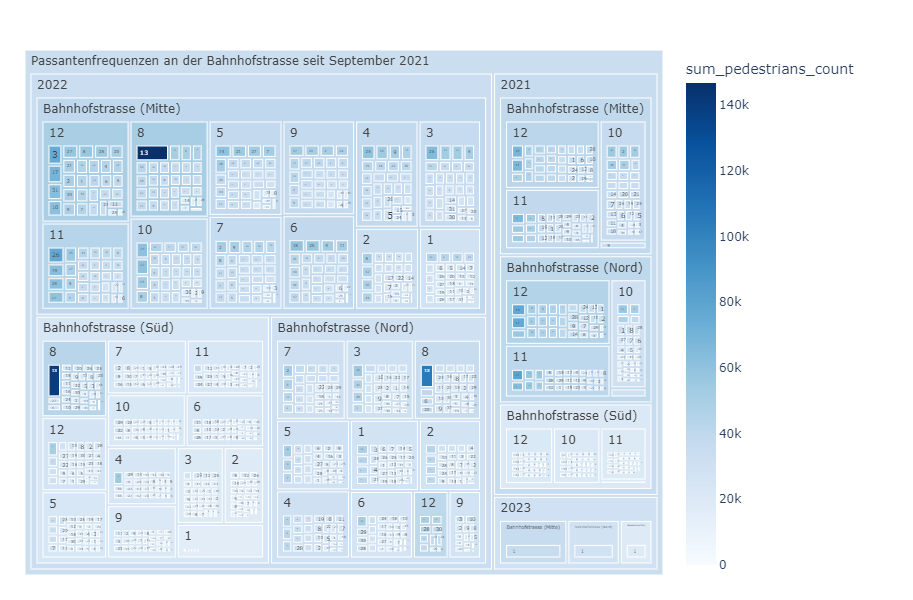

In [66]:
myTitle = "Passantenfrequenzen an der Bahnhofstrasse seit September 2021"

fig = px.treemap(myTreemapAgg.query('sum_pedestrians_count>0').reset_index(), path=[px.Constant(myTitle), 'year','location_name', 'month','day']
                 , values='sum_pedestrians_count'
                 , color='sum_pedestrians_count'
                 ## bei discrete scales (bei Klassen und Strings):                 
                 #, color_discrete_map={'(?)':'lightgrey','EVP':'gold', 'SP':'#FF3030', 'PdA':'#EE3B3B', 'Grüne':'#A2CD5A','GLP':'#CAFF70','Die Mitte':'orange','FDP':'#104E8B','AL':'deeppink','SVP':'forestgreen', 'FL ZÜRI':'#8B864E','Volt':'#lightblue' }                
                 ## bei continuous scales (bei Zahlenwerten):
                , color_continuous_scale='Blues'
                #, color_continuous_midpoint=np.average(df['AnzBestWir'], weights=df['AnzBestWir'])  
                 ,height=600
                 ,width=1100                 
                )
fig.update_traces(root_color="grey")
fig.update_layout(margin = dict(t=50, l=25, r=250, b=25))
fig.show()

In [67]:
#data2betested.head(20)

---------

## --- Plausi stopped here

#### Aktueller Bestand der WBev nach Quartier und Herkunft

In [68]:
#data2betested.columns

In [69]:
myTreemapAgg = data2betested.loc['2021']  \
    .groupby(['StichtagDatJahr', 'QuarLang', 'HerkunftLang']) \
    .agg(sum_WBev=('AnzBestWir', 'sum')) \
    .sort_values('sum_WBev', ascending=True) 

myTreemapAgg.reset_index().head(3)

KeyError: 'StichtagDatJahr'

In [ ]:
myTitle = "WBev nach Quartier und Herkunft, 2021"

fig = px.treemap(myTreemapAgg.reset_index(), path=[px.Constant(myTitle), 'StichtagDatJahr', 'QuarLang', 'HerkunftLang']
                 , values='sum_WBev'
                 , color='HerkunftLang'
                 ## bei discrete scales (bei Klassen und Strings):                 
                 #, color_discrete_map={'(?)':'lightgrey','EVP':'gold', 'Ausländer/in':'#FF3030', 'PdA':'#EE3B3B', 'Grüne':'#A2CD5A','GLP':'#CAFF70','Die Mitte':'orange','FDP':'#104E8B','AL':'deeppink','SVP':'forestgreen', 'FL ZÜRI':'#8B864E','Volt':'#lightblue' }         
                 , color_discrete_map={'(?)':'lightgrey','Schweizer/in':'gold', 'SP':'#FF3030' }               
                 ## bei continuous scales (bei Zahlenwerten):
                , color_continuous_scale='blues'
                #, color_continuous_midpoint=np.average(df['AnzBestWir'], weights=df['AnzBestWir'])   
                 ,height=400
                 ,width=1100
                )
fig.update_traces(root_color="grey")
fig.update_layout(margin = dict(t=50, l=25, r=250, b=25))
fig.show()

In [ ]:
#data2betested.dtypes

## ---------------------- hier Plausi beendet

**Sharepoint als gecheckt markieren!**

Record auf Sharepoint: **[Link](https://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/DispForm.aspx?ID=115&ContentTypeId=0x0100988EAF029F1EFE4CA675F53C32A5D53D01006DBC563E6FBE9E4EB6FDC780799752E1)**

---------------------------------------------------------------------------

### Test: Choroplethenkarte
Importiere die Geodaten als GeoJSON

#### Stadtkreise

In [ ]:
# Read abt. Geopandas https://geopandas.org/docs/user_guide/io.html
geojson_url_kreise = "https://www.ogd.stadt-zuerich.ch/wfs/geoportal/Stadtkreise?service=WFS&version=1.1.0&request=GetFeature&outputFormat=GeoJSON&typename=adm_stadtkreise_v"
adm_stadtkreise_v = gpd.read_file(geojson_url_kreise)

adm_stadtkreise_v.head(1)


#### Statistische Zonen

In [ ]:
# Read abt. Geopandas https://geopandas.org/docs/user_guide/io.html
geojson_url_statzonen = "https://www.ogd.stadt-zuerich.ch/wfs/geoportal/Statistische_Zonen?service=WFS&version=1.1.0&request=GetFeature&outputFormat=GeoJSON&typename=adm_statzonen_map"
adm_statzonen_map = gpd.read_file(geojson_url_statzonen)

adm_statzonen_map.head(2)


#### Statistische Quartiere

In [ ]:
geojson_url_quartiere = "https://www.ogd.stadt-zuerich.ch/wfs/geoportal/Statistische_Quartiere?service=WFS&version=1.1.0&request=GetFeature&outputFormat=GeoJSON&typename=adm_statistische_quartiere_map"
df_adm_statistische_quartiere_map = gpd.read_file(geojson_url_quartiere)

df_adm_statistische_quartiere_map.head(2)


### Teste LeafMap

Mehr Infos: https://leafmap.org/leafmap/

In [ ]:
m = leafmap.Map()

#m.add_geojson(geojson_url_kreise, layer_name="adm_stadtkreise_v", fill_colors=['red', 'yellow', 'green', 'orange'], info_mode=True)
m.add_gdf(df_adm_statistische_quartiere_map, layer_name='adm_statistische_quartiere_map', style={}, hover_style={}, style_callback=None, fill_colors=['black'], info_mode='on_hover', zoom_to_layer=True)
m.add_gdf(adm_stadtkreise_v, layer_name='adm_stadtkreise_v', style={}, hover_style={}, style_callback=None, fill_colors=['none'], info_mode='on_hover', zoom_to_layer=False)

m.add_legend(title='Legende', legend_dict=None, labels=None, colors=None, position='bottomright', builtin_legend=None, layer_name='adm_statistische_quartiere_map')
m

### Joins
Joine die importierten statistischen Daten des aktuellen Jahres zum Geodatensatz:

*Siehe dazu Doku zu [Geopandas](https://geopandas.org/docs/user_guide/mergingdata.html)*

In [ ]:
#data2betested.dtypes
data2betested.head()

In [ ]:
myAgg = data2betested.loc["2020"]  \
    .copy() \
    .groupby(['QuarLang', 'QuarCd']) \
    .agg(sum_AnzBestWir=('AnzBestWir', 'sum')) \
    .assign() \
    .sort_values('QuarCd', ascending=False) 

#myAgg.reset_index()


In [ ]:
# Rename attribute stznr to StatZoneSort, so the IDs have the same name
gdf_adm_statistische_quartiere_map = df_adm_statistische_quartiere_map[['geometry', 'qnr', 'qname', 'knr']].rename(columns={'qnr': 'QuarCd'})
gdf_adm_statistische_quartiere_map.head(1)

#### Leftjoin 
Matche die statistischen Daten mit den Geodaten

In [ ]:
# Merge with `merge` method on shared variable (stznr und StatZoneSort):
gdf_adm_statistische_quartiere_map_joined = gdf_adm_statistische_quartiere_map.merge(myAgg, on='QuarCd', how="left") #'right', 'inner', 'left'
gdf_adm_statistische_quartiere_map_joined.head(2)


In [ ]:
#does all match?
gdf_adm_statistische_quartiere_map_joined.isnull().sum()

In [ ]:
# Plot by StatQuartiere
# Weitere Schemes: scheme='quantiles', scheme='fisherjenks', scheme='natural_breaks',

gdf_adm_statistische_quartiere_map_joined.plot(column='sum_AnzBestWir', cmap='viridis', scheme='natural_breaks', legend=True )
gdf_adm_statistische_quartiere_map_joined.plot(column='sum_AnzBestWir', cmap='viridis', scheme='fisherjenks', legend=True )

#scheme werte: https://matplotlib.org/2.0.2/users/colormaps.html

#
#Neuere Gallerie: https://matplotlib.org/stable/gallery/index.html

In [ ]:
fig, ax = plt.subplots(1, 1)

gdf_adm_statistische_quartiere_map_joined.plot(column='sum_AnzBestWir', ax=ax, legend=True, legend_kwds={'label': "Anzahl WBev 2020",'orientation': "horizontal"})
#gdf_adm_statistische_quartiere_map_joined.plot(column='sum_AnzBestWir', ax=ax, legend=False, legend_kwds={'label': "Anzahl WBev 2020",'orientation': "horizontal"})

#gdf_adm_statistische_quartiere_map_joined.plot(column='sum_Whg_abgebrochen', cmap='viridis', scheme='natural_breaks', legend=True , ax=ax, legend_kwds={'label': "Anzahl Personen",'orientation': "horizontal"})

Noch zu prüfen, folgendes schöne Beispiel: https://docs.bokeh.org/en/latest/docs/user_guide/interaction/legends.html

Konkrete Beispiele von Bookeh in Jupyter NB: https://docs.bokeh.org/en/latest/docs/user_guide/jupyter.html

Noch zu prüfen, folgendes schöne Beispiel: https://docs.bokeh.org/en/latest/docs/user_guide/interaction/legends.html

Konkrete Beispiele von Bookeh in Jupyter NB: https://docs.bokeh.org/en/latest/docs/user_guide/jupyter.html

**Sharepoint als gecheckt markieren!**

Record auf Sharepoint: **[Link](https://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/DispForm.aspx?ID=115&ContentTypeId=0x0100988EAF029F1EFE4CA675F53C32A5D53D01006DBC563E6FBE9E4EB6FDC780799752E1)**